In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../../data/crime-data-versions/v11crimedata.csv")

In [3]:
df.head()

,Incident UID,Agency,Incident Date,CIBRS Unique Offense ID,CIBRS Offense Code,CIBRS Offense Description,Victim UID,Victim Category,Victim Age,Overall Race,City,Zip Code,CIBRS Status,Domestic Violence Incident,HHSA Region
0,661987,SAN DIEGO,2021-02-18 17:40:00,661987-13A-679864,13A,Aggravated Assault,679864,I,22,HISPANIC,SAN DIEGO,92037,ProcessingComplete - Valid,True,NORTH CENTRAL
1,793674,SAN DIEGO,2021-03-16 05:30:00,793674-11A-818279,11A,Forcible Rape,818279,I,41,WHITE,SAN DIEGO,92110,ProcessingComplete - Valid,False,NORTH CENTRAL
2,859375,NATIONAL CITY,2021-03-22 14:25:00,859375-11A-887268,11A,Forcible Rape,887268,I,22,HISPANIC,NATIONAL CITY,91950,ProcessingComplete - Valid,False,SOUTH
3,658884,SAN DIEGO,2021-03-24 12:00:00,658884-13B-676587,13B,Simple Assault,676587,I,45,HISPANIC,SAN DIEGO,92101,ProcessingComplete - Valid,True,CENTRAL
4,721771,CARLSBAD,2021-05-04 18:54:00,721771-13B-743217,13B,Simple Assault,743217,I,28,HISPANIC,CARLSBAD,92011,ProcessingComplete - Valid,False,NORTH COASTAL


# Goal: Predict what type of incident is more likely to occur for a victim given demographics and location
## Logistic Regression: 
- Input Victim Age, Overall Race, Zip Code, and Domestic Violence Incident (maybe?) to predict CIBRS Offense Description
- Could also try analyzing based on HHSA Region as well to see what difference it makes, if any
- Try creating separate columns extracting the day of week, month, date, hour to see if that makes any difference
- Could try Decision Trees also to make it more visually appealing?
 
## Feature Selection: 
- Analyze which features contrbibute most to the classification of offense description, which variables are more correlated

# Logistic Regression
## Step 1: Conducting EDA for insights on the Offense Description data

In [6]:
import matplotlib.pyplot as plt

<Figure size 1200x600 with 0 Axes>

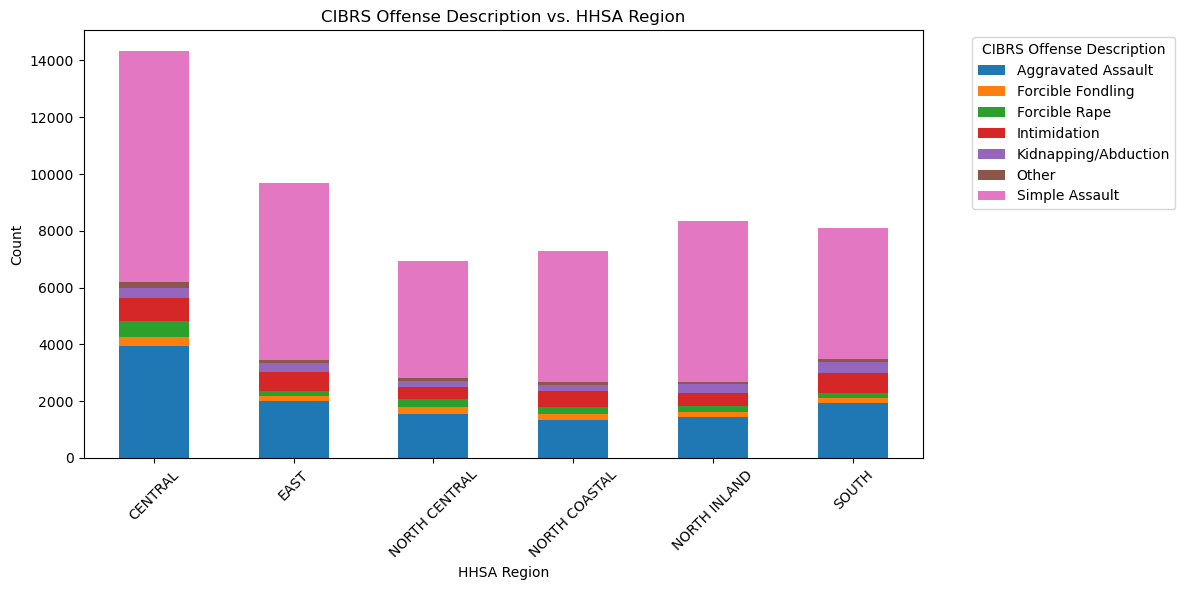

In [7]:
# Plotting 'CIBRS Offense Description' vs. 'HHSA Region'
plt.figure(figsize=(12, 6))
offense_region = df.groupby(['HHSA Region', 'CIBRS Offense Description']).size().unstack()
offense_region.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('CIBRS Offense Description vs. HHSA Region')
plt.xlabel('HHSA Region')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='CIBRS Offense Description', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

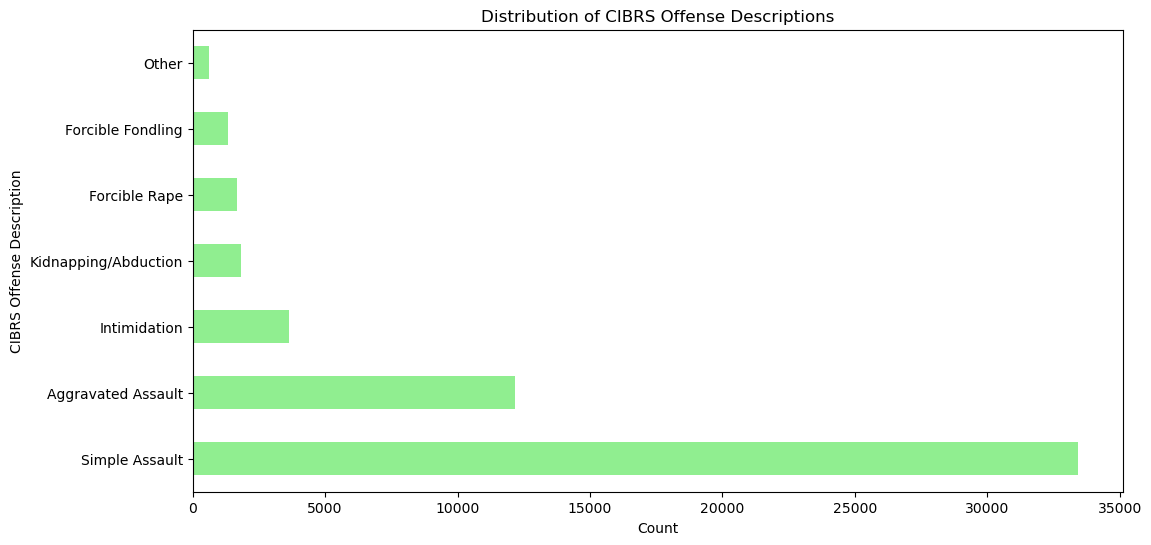

In [8]:
# Plotting 'CIBRS Offense Description' distribution
plt.figure(figsize=(12, 6))
df['CIBRS Offense Description'].value_counts().plot(kind='barh', color='lightgreen')
plt.title('Distribution of CIBRS Offense Descriptions')
plt.xlabel('Count')
plt.ylabel('CIBRS Offense Description')
plt.show()

In [9]:
import seaborn as sns

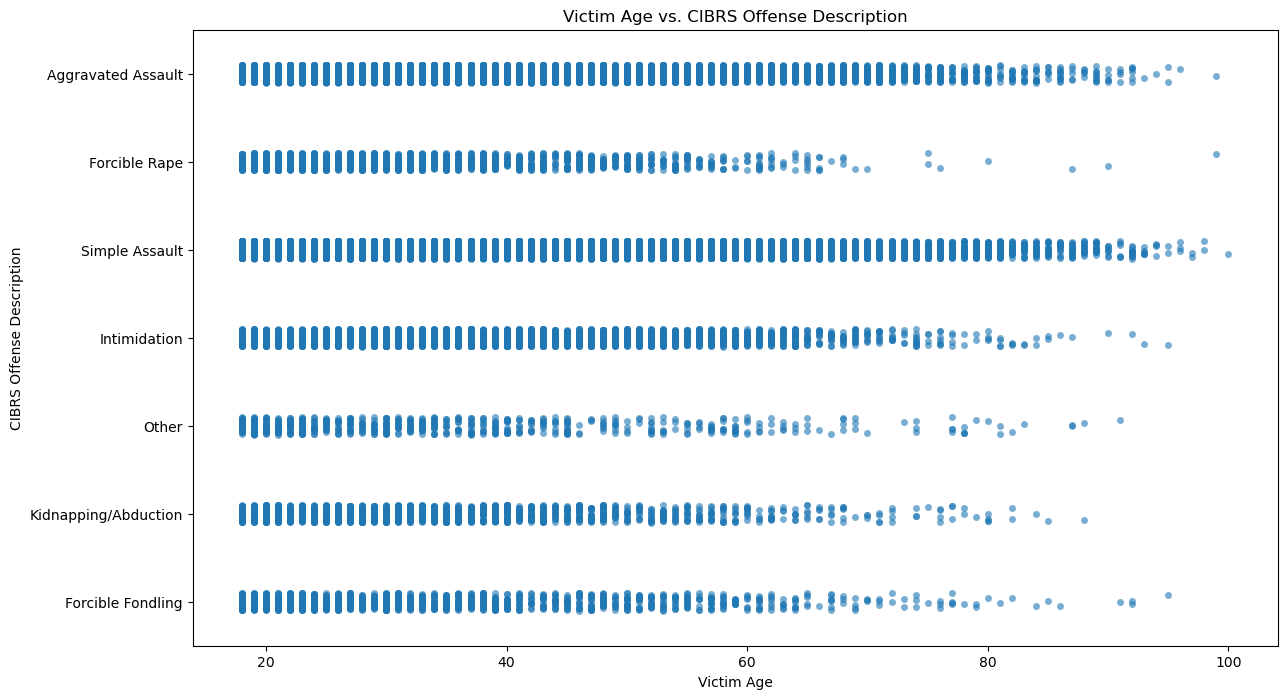

In [10]:
# Strip plot of Victim Age vs. CIBRS Offense Description
plt.figure(figsize=(14, 8))
sns.stripplot(data=df, x='Victim Age', y='CIBRS Offense Description', jitter=True, alpha=0.6)
plt.title('Victim Age vs. CIBRS Offense Description')
plt.xlabel('Victim Age')
plt.ylabel('CIBRS Offense Description')
plt.show()

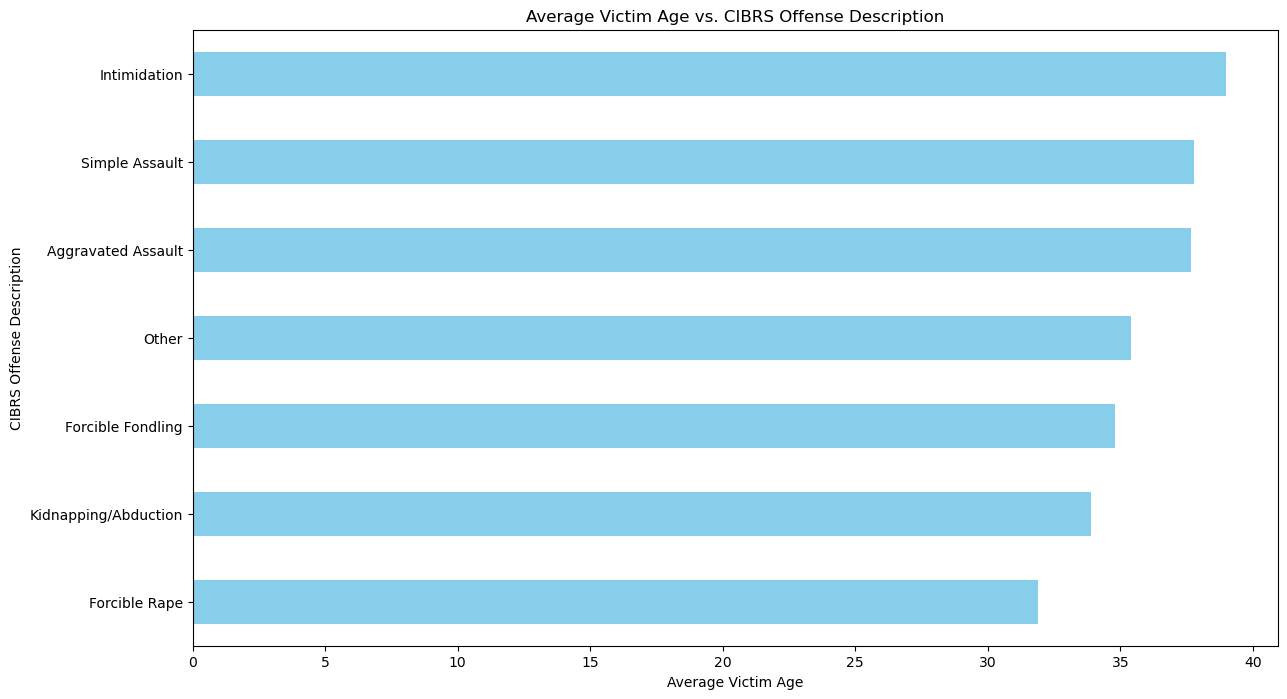

In [11]:
# Bar chart of average Victim Age vs. CIBRS Offense Description
plt.figure(figsize=(14, 8))
avg_age_offense = df.groupby('CIBRS Offense Description')['Victim Age'].mean().sort_values()
avg_age_offense.plot(kind='barh', color='skyblue')
plt.title('Average Victim Age vs. CIBRS Offense Description')
plt.xlabel('Average Victim Age')
plt.ylabel('CIBRS Offense Description')
plt.show()

<Figure size 1400x800 with 0 Axes>

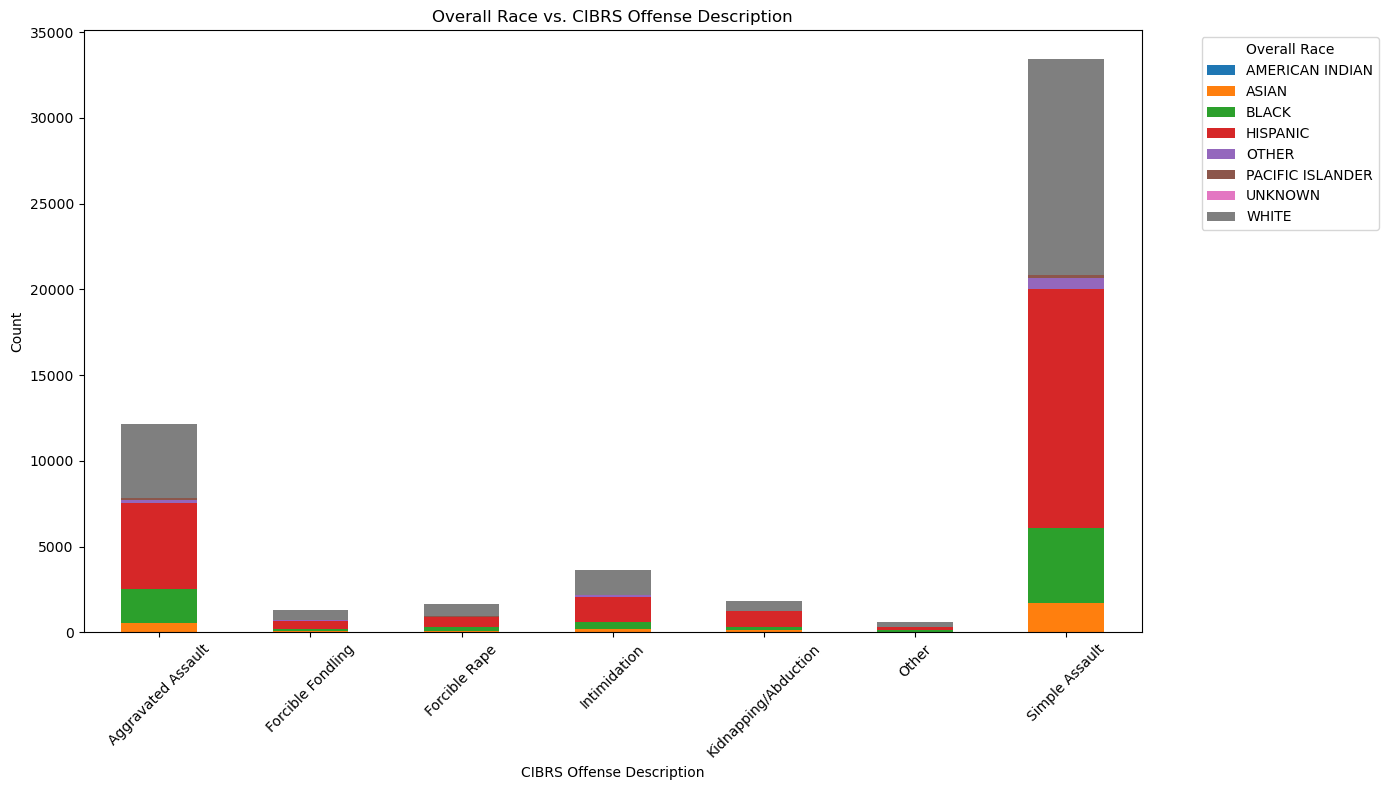

In [12]:
# Bar chart of Overall Race vs. CIBRS Offense Description
plt.figure(figsize=(14, 8))
offense_race = df.groupby(['CIBRS Offense Description', 'Overall Race']).size().unstack()
offense_race.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Overall Race vs. CIBRS Offense Description')
plt.xlabel('CIBRS Offense Description')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Overall Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Results:

- Visually, we can see that the Central HHSA Region has the highest incident count. North Central has the lowest overall incident count. Within each of the regions, Aggravated Assault and Simple Assault take up most of the incidents.
- Simple Assualt has the highest count at around 34,000, while Aggravated Assault falls behind at around 12,000. Everything else has count under 4,000.
- The incidents have the most even distributions over age are Simple Assault (most even) and Aggravated Assault. Those that are most age-dependent and have a higher impact on younger ages are Forcible Rape, Kipnapping/Abduction, and Forcible Fondling. The 'Other' category is also very dpependent on age and is right-skewed.
- Looking at the average ages for each of the types of incidents, intimidation has the highest average age at almost 40 years old. Forcible Rape has the lowest average age at around 32. The 'Other' category is right in the middle.
- Grouping incident types by race, all of them are majority Hispanic and White, then Black and Asian. 

## Step 2: Getting the data ready to fit the model

- Add columns from the Incident Date column so we can use Hour, Day of Week, Day of Month, and Month in our Logistic Regression model

In [15]:
# convert to datetime

df['Incident Date'] = pd.to_datetime(df['Incident Date'])

In [16]:
df['Hour'] = df['Incident Date'].dt.hour

In [17]:
df['Day of Week'] = df['Incident Date'].dt.weekday

In [18]:
weekday_map = {0: 'MONDAY', 1: 'TUESDAY', 2: 'WEDNESDAY', 3: 'THURSDAY', 4: 'FRIDAY', 5: 'SATURDAY', 6: 'SUNDAY'}
df['Day of Week'] = df['Day of Week'].map(lambda x: weekday_map[x])

In [19]:
df['Month'] = df['Incident Date'].dt.month

In [21]:
df['Day of Month'] = df['Incident Date'].dt.day

In [40]:
df.head()

,Incident UID,Agency,Incident Date,CIBRS Unique Offense ID,CIBRS Offense Code,CIBRS Offense Description,Victim UID,Victim Category,Victim Age,Overall Race,City,Zip Code,CIBRS Status,Domestic Violence Incident,HHSA Region,Hour,Day of Week,Month,Day of Month
0,661987,SAN DIEGO,2021-02-18 17:40:00,661987-13A-679864,13A,Aggravated Assault,679864,I,22,HISPANIC,SAN DIEGO,92037,ProcessingComplete - Valid,True,NORTH CENTRAL,17,THURSDAY,2,18
1,793674,SAN DIEGO,2021-03-16 05:30:00,793674-11A-818279,11A,Forcible Rape,818279,I,41,WHITE,SAN DIEGO,92110,ProcessingComplete - Valid,False,NORTH CENTRAL,5,TUESDAY,3,16
2,859375,NATIONAL CITY,2021-03-22 14:25:00,859375-11A-887268,11A,Forcible Rape,887268,I,22,HISPANIC,NATIONAL CITY,91950,ProcessingComplete - Valid,False,SOUTH,14,MONDAY,3,22
3,658884,SAN DIEGO,2021-03-24 12:00:00,658884-13B-676587,13B,Simple Assault,676587,I,45,HISPANIC,SAN DIEGO,92101,ProcessingComplete - Valid,True,CENTRAL,12,WEDNESDAY,3,24
4,721771,CARLSBAD,2021-05-04 18:54:00,721771-13B-743217,13B,Simple Assault,743217,I,28,HISPANIC,CARLSBAD,92011,ProcessingComplete - Valid,False,NORTH COASTAL,18,TUESDAY,5,4


## Step 3: Fitting the model